# HW5.1 text classification with logistic regression. 

We will use the same dataset Triage as last time. Here is what's in this assignment: 

1. we will explore several options of how to convert text to vectors to be fed into a logistic regression classifier using sklearn. 
2. we will implement and train a logistic regression classifier using Python (no sklearn!).
3. we will compare the text classification result with those you got from the NB last week. 

## PART I: text input representation: converting text to vectors

There are many ways to convert text to vectors. Let's try two ways in this assignment. 

1. Count vectors 

Read the documentation for sklearn ```CountVectorizer``` here: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit_transform 

2. Normalized counts - tfidf

Read the documentation for sklearn ```tfidfVectorizer``` here: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

Make sure you understood the code examples for those two vectorizers. 



In [1]:
#loading all the necessary packages

from sklearn.feature_extraction.text import TfidfVectorizer
from util import load_data, Dataset, Example
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

from sklearn import preprocessing 


### logistic regression with unigram count vectors


In [2]:
dataset = load_data("./data/triage")

corpus = ['this is the first document',
          'this document is the second document',
          'and this is the third one',
          'is this the first document',
          'how about these documents']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)


#### you turn: read the Triage dataset using the same loader from last time, and convert your text documents into a count vector. 

In [3]:
def get_data(split: list[Example]) -> (list[str], list[int]):
    """
    Massage the data into a format consistent with the input type required by CountVectorizer or TfidfVectorizer. 

    Args:
        split: pass in the split, which should be either dataset.train or dataset.dev

    Returns: 
        text: list of sentences
        labels: list of labels  
    """
    # Extract texts and labels from the Example objects
    texts = [" ".join(example.words) for example in split]  
    labels = [example.label for example in split]

    return texts, labels


In [4]:
train_text, train_label = get_data(dataset.train)
dev_text, dev_label = get_data(dataset.dev)

#### load the data using get_data() and then convert them into count vector
```
train_text, train_label = get_data(dataset.train)
dev_text, dev_label = get_data(dataset.dev)
```

#### IMPORTANT note: 
You need to transform both train and dev data into a vector before feeding them into a classifier. But ```fit_transform()``` is a composition of two functions: fit and transform. 
You should use ```fit_transform()``` to fit the vector to your train text and transform it to the vector,
but when you deal with the dev text, you don't need to fit the Vectorizer any more, you just need to use the 
Vectorizer you fit on the train data, and simply ```transform()``` it. Don't use ```fit_transform()``` on both data splits. 
To confirm that you are using the same Vectorizer for both train data and test data, you should get the feature names out
and see that they have the same length. 
e.g., : 

```
names=vectorizer.get_feature_names_out()
print(len(names))
```

Because the train and dev split have different vocabulary sizes, if you ```fit_transform``` on each of them you will end up with vectors of different lengths. Since your classifier is trained with the input vector length from train, it should not take input with a different vector length on the dev data. 

## Part I: logistic regression with bigram count vectors

When using the CountVectorizer, you can also use bigram or Ngram counts. If you read the documentation for  ```CountVectorizer``` above, you will find the argument called ```ngram_range```. Try to use both unigrams and bigrams for this task. 

### Part I: Unigram Vectorizer 


In [5]:
# Initialize vectorizer with unigram and bigram setting
vectorizer_uni = CountVectorizer(ngram_range=(1, 1))

# Fit and transform the training data
train_vector_uni = vectorizer_uni.fit_transform(train_text)

# Only transform the development data using the same vectorizer
dev_vector_uni = vectorizer.transform(dev_text)

# Confirm the length of the vocabulary to ensure we used the same one for both train and dev data
names = vectorizer_uni.get_feature_names_out()
# print(len(names))


### Part I: Bigram Vectorizer 

In [6]:

# Initialize vectorizer with unigram and bigram setting
vectorizer_bi = CountVectorizer(ngram_range=(1, 2))

# Fit and transform the training data
train_vector_bi = vectorizer_bi.fit_transform(train_text)

# Only transform the development data using the same vectorizer
dev_vector_bi = vectorizer.transform(dev_text)

# train_vector_bi = train_vector_bi.toarray()
# dev_vector_bi = dev_vector_bi.toarray()

# Confirm usage of the same vocab for train and test (dev) data
names = vectorizer_bi.get_feature_names_out()
# print(len(names))


### Part I: logistic regression with tfidf vectors

In [7]:
# Refer to the tfidfVectorizer linked above to transform the text into tfidf vectors

# Initialize the TF-IDF vectorizer with unigram and bigram setting
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
train_tfidf_vector = tfidf_vectorizer.fit_transform(train_text)

# Only transform the development data using the same vectorizer
dev_tfidf_vector = tfidf_vectorizer.transform(dev_text)



### Part I: Feature exploration

In [8]:
# Get the feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Print the length of the vector (number of features)
print(f"Length of the vector: {len(feature_names)}")

# Printing the first 10 features
print("\nFirst 10 features:")
print(feature_names[:10])
#printing the middle 10 features 
print("\nFeatures from the middle:")
print(feature_names[len(feature_names) // 2 : len(feature_names) // 2 + 10])
#printing the last 10 features
print("\nLast 10 features:")
print(feature_names[-10:])

Length of the vector: 31211

First 10 features:
['00' '000' '0000' '000ha' '000l' '000lt' '000m2' '000rmb' '004' '00h58']

Features from the middle:
['khatami' 'khatir' 'khatlon' 'khattak' 'khatun' 'khaw' 'khdara' 'kheda'
 'khel' 'khiar']

Last 10 features:
['état' 'été' 'ötanos' 'üan' 'üaram' 'üei' 'ühurricane' 'ülol' 'üthe'
 'üthis']


# PART II: Logistic regression from scratch

We have seen in class there are four components in a standard linear classifier: features (input), forward pass (function to compute p(Y|X)), a loss function (to measure the errors the system makes), and the optimizer/iterative learning process to adjust the weights to minimize the errors. We've already taken care of the input features above. Let's now implement the rest of the components. Let's use the tfidf vectors for this implemetation.

Recipe: 
```
   1. Initialize the parameters
Repeat {
   2. Make a prediction y_hat
   3. Calculate loss function
   4. Get gradient for loss function
   5. Update parameters W, b
 }
```

In [9]:
Xtrain, Xtest = train_tfidf_vector, dev_tfidf_vector
Ytrain = np.array(train_label)
Ytest = np.array(dev_label)

# randomly initialize weights
D = Xtrain.shape[1]
W = np.random.randn(D)
b = 0 # bias term

# make predictions
def sigmoid(z):
    """
    sigmoid function
    
    args
        z: the result of linear computation, z = X.dot(W) + b
    """
    
    return 1 / (1 + np.exp(-z))
    

def forward(X, W, b):
    """
    forward pass, return the result of passing X.dot(W)+b through sigmoid function

    args
        X: input features
        W: weights
        b: biases
    """
    return sigmoid(X.dot(W) + b)



# calculating the accuracy
def classification_rate(Y, Y_HAT):
    return np.mean(Y == Y_HAT)

# return cross entropy
def cross_entropy(T, pY):
    return -np.mean(T*np.log(pY) + (1 - T)*np.log(1 - pY))

# train loop

# storing the loss values during the training (used later for visualization)
train_loss = [] 
test_loss = []

learning_rate = 0.001
num_iter = 10000 # iterate this many times to update the weights

for i in tqdm(range(num_iter)):
    
    # Forward pass for train data
    p_Ytrain = forward(Xtrain, W, b)
    
    # Forward pass for test data
    p_Ytest = forward(Xtest, W, b)
    
    # Compute cross-entropy loss for both train and test data
    train_loss.append(cross_entropy(Ytrain, p_Ytrain))
    test_loss.append(cross_entropy(Ytest, p_Ytest))
    
    # Compute gradients for weight and bias updates
    dw = Xtrain.T.dot(p_Ytrain-Ytrain)
    db = np.sum(p_Ytrain - Ytrain)
    
    # Update weights and biases
    W -= learning_rate * dw
    b -= learning_rate * db


100%|████████████████████████████████████| 10000/10000 [00:13<00:00, 750.25it/s]


Final train classification_rate: 0.9354271595552599
Final test classification_rate: 0.757870190439176


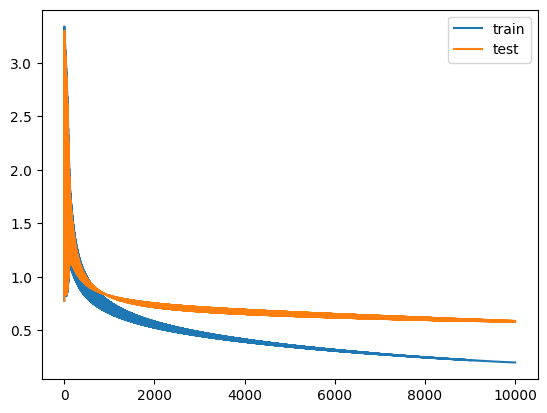

In [10]:
# evaluate your model after it is trained. What is the accuracy? 
print("Final train classification_rate:", classification_rate(Ytrain, np.round(p_Ytrain)))
print("Final test classification_rate:", classification_rate(Ytest, np.round(p_Ytest)))
# import matplotlib as plt 

# finally plot the trajectory of the training curve 
legend1, = plt.plot(train_loss, label='train loss')
legend2, = plt.plot(test_loss, label='test loss')
plt.legend(["train", "test"])
plt.show()

# PART III: compare different vectors

Now substitute the tfidf vectors with the unigram, and unigram+bigram count vectors. Train the model again. How is the accuracy this time?

### Part III: Unigram Normalizing and model training 

100%|████████████████████████████████████| 10000/10000 [00:14<00:00, 686.75it/s]


Final train classification rate for unigram: 0.8003896227311603
Final test classification_rate for unigram: 0.7407695297318305


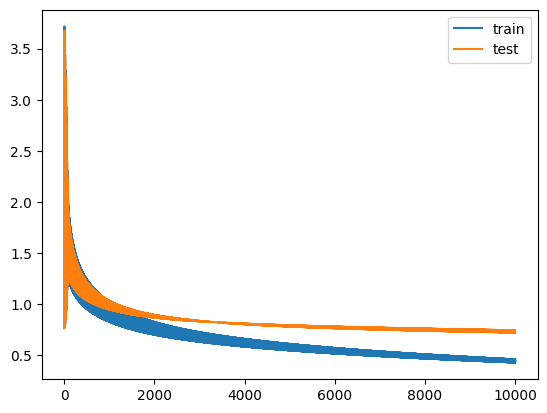

In [11]:
#need to normalize train and test 

# Create a unigram vectorizer
vectorizer = CountVectorizer(ngram_range=(1, 1))

# Fit and transform the training data
train_vector_uni = vectorizer.fit_transform(train_text)

# Transform the test data using the same vectorizer
dev_vector_uni = vectorizer.transform(dev_text)


Xtrain = train_vector_uni
Xtest = dev_vector_uni

Ytrain = np.array(train_label)
Ytest = np.array(dev_label)

Xtrain  = preprocessing.normalize(Xtrain)   #preprocessing  the train for the unigram 
Xtest = preprocessing.normalize(Xtest)   #preprocessing the test for the unigram


# randomly initialize weights
D = Xtrain.shape[1]
W = np.random.randn(D)
b = 0 # bias term

# use these lists to store the loss values during the training, so you can visualize them later in a curve
train_loss = [] 
test_loss = []

learning_rate = 0.001
num_iter = 10000 # iterate this many times to update the weights


for i in tqdm(range(num_iter)):
    # Forward pass for train data
    p_Ytrain = forward(Xtrain, W, b)
    # Forward pass for test data
    p_Ytest = forward(Xtest, W, b)
    
    # Compute cross-entropy loss for both train and test data
    train_loss.append(cross_entropy(Ytrain, p_Ytrain))
    test_loss.append(cross_entropy(Ytest, p_Ytest))

    dw = Xtrain.T.dot(p_Ytrain-Ytrain)
    db = np.sum(p_Ytrain - Ytrain)
    # Update weights and biases
    W -= learning_rate * dw
    b -= learning_rate * db
    
#plotting the results of the unigram

# evaluate your model after it is trained. What is the accuracy? 
print("Final train classification rate for unigram:", classification_rate(Ytrain, np.round(p_Ytrain)))
print("Final test classification_rate for unigram:", classification_rate(Ytest, np.round(p_Ytest)))

# finally plot the trajectory of the training curve 
legend1, = plt.plot(train_loss, label='train loss')
legend2, = plt.plot(test_loss, label='test loss')
plt.legend(["train", "test"])
plt.show()

### Part III: Bigram Normalizing and model training


100%|████████████████████████████████████| 10000/10000 [00:29<00:00, 334.29it/s]


Final train classification_rate for bigram: 0.9791884443599734
Final test classification_rate for bigram: 0.7629226583754373


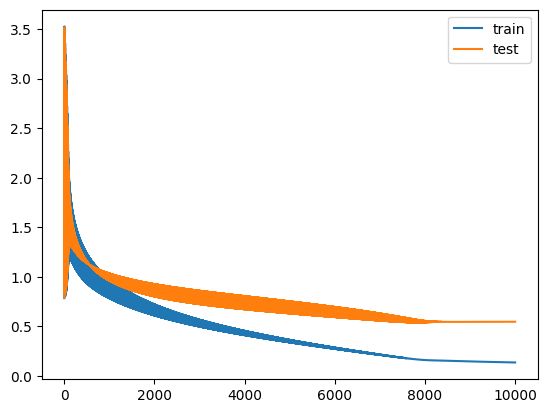

In [12]:
#classifying for bigram 

# Create a unigram vectorizer
vectorizer_two = CountVectorizer(ngram_range=(1, 2))

# Fit and transform the training data
train_vector_two = vectorizer_two.fit_transform(train_text)

# Transform the test data using the same vectorizer
dev_vector_two = vectorizer_two.transform(dev_text)


Xtrain = train_vector_two
Xtest = dev_vector_two

Ytrain = np.array(train_label)
Ytest = np.array(dev_label)

Xtrain  = preprocessing.normalize(Xtrain)   #preprocessing  the train for the unigram 
Xtest = preprocessing.normalize(Xtest)   #preprocessing the test for the unigram


# randomly initialize weights
D = Xtrain.shape[1]
W = np.random.randn(D)
b = 0 # bias term

# use these lists to store the loss values during the training, so you can visualize them later in a curve
train_loss = [] 
test_loss = []

learning_rate = 0.001
num_iter = 10000 # iterate this many times to update the weights


for i in tqdm(range(num_iter)):
    # Forward pass for train data
    p_Ytrain = forward(Xtrain, W, b)
    # Forward pass for test data
    p_Ytest = forward(Xtest, W, b)
    
    # Compute cross-entropy loss for both train and test data
    train_loss.append(cross_entropy(Ytrain, p_Ytrain))
    test_loss.append(cross_entropy(Ytest, p_Ytest))

    dw = Xtrain.T.dot(p_Ytrain-Ytrain)
    db = np.sum(p_Ytrain - Ytrain)
    # Update weights and biases
    W -= learning_rate * dw
    b -= learning_rate * db
# evaluate your model after it is trained. What is the accuracy? 
print("Final train classification_rate for bigram:", classification_rate(Ytrain, np.round(p_Ytrain)))
print("Final test classification_rate for bigram:", classification_rate(Ytest, np.round(p_Ytest)))
# import matplotlib as plt 

from matplotlib import pyplot as plt
import numpy as np


# finally plot the trajectory of the training curve 
legend1, = plt.plot(train_loss, label='train loss')
legend2, = plt.plot(test_loss, label='test loss')
plt.legend(["train", "test"])
plt.show()

# wrapping up

##### You should see your training curve on your train data and dev data above. What do you observe? 

##### How does your final train and dev accuracy compare to using NaiveBayes model from last week?

Compared to the NaiveBayes Model from last week, it seems that our models here (bigram and tfidf in particular) are overfitting, as the train accuracy, compared to test accuracy, is very high. Although, in all three cases, we observe relatively high test accuracy as well.

Among all three cases, we notice that as we increase the number of epochs, the loss decreases both in test and train. We do observe a lower train loss, which is expected, as we trained the model directly on the train data. The gap between the blue (train) and orange (test) lines may indicate the overfitting we observe in some cases. As we noted above, our model did exceptionally well in the case of the bigram and tfidf train models, achieving an accuracy close to 97% and 93% respectively.

Overall, our models seem to perform well, given our high test accuracy rates.